## Callibration code
Code for callibration: drawing lines at various z heights for establishing the r-z relationship.

In the RL output (x, y, r, l, theta...), x and y (\in [0,1]) denote meters, while r = r_real / img_width represents the ratio of r to the real character width.

To obtain the actual radius width, we can simply scale it by a factor α (e.g., α = 0.08 signifies writing a character with a width of 0.08 m).

For calibration purposes, we seek to determine the correlation between r (cm) and z (cm), represented as a function(). Subsequently, we apply this function to convert RL fine-tuned states into NPZ-like x-y-z control points.

### 1. Tool Callibration and generate the callibration function


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

in the following code block, you have to use your robot arm to find out the maximum z-height (pen touching the paper) and minimmum z-height (pen pressing on the paper, to the extreme), and generate 'its' number of samples.

In [2]:
## E.g. 1: our Calligraphy brush

max_z = 0.01 # measure: m
min_z = -0.006 # measure: m
its = 17
zs = np.linspace(max_z, min_z,its).round(4)
zs = np.sort(np.unique(zs))[::-1]
print(zs)
savedir = './test/'
if not os.path.exists(savedir):
    os.mkdir(savedir)

[ 0.01   0.009  0.008  0.007  0.006  0.005  0.004  0.003  0.002  0.001
  0.    -0.001 -0.002 -0.003 -0.004 -0.005 -0.006]


In [88]:
## E.g. 1: our Fude pen

max_z = 0.04602 # measure: m
min_z = 0.044250 # measure: m
its = 8
zs = np.linspace(max_z, min_z,its).round(7)
zs = np.sort(np.unique(zs))[::-1]
print(zs)
savedir = './test/'
if not os.path.exists(savedir):
    os.mkdir(savedir)


[0.04602   0.0457671 0.0455143 0.0452614 0.0450086 0.0447557 0.0445029
 0.04425  ]


In [27]:
def generate_npz(zs, max_z, savedir):
    # generate 'its' number of strokes with linear z range from max_z (small r) to min_z (large r)
    x = []
    y = []
    z = []
    for i in range(zs.shape[0]):
        ## begin point
        x.append(0)
        y.append(i*0.004)
        z.append(max_z + 0.03)
        
        ## left point with current z
        x.append(0)
        y.append(i*0.004)
        z.append(zs[i])
        
        ## right point with current z
        x.append(0.05)
        y.append(i*0.004)
        z.append(zs[i])
        
        ## lift pen
        x.append(0.05)
        y.append(i*0.004)
        z.append(max_z + 0.03)
    
    print("make test data...")
    np.savez(os.path.join(savedir,"test.npz"), pos_3d_x=x, pos_3d_y=y, pos_3d_z=z)    

thus we utilize our robotic arm to draw the lines...

In [28]:
generate_npz(zs, max_z, savedir)
from RoboControl import *

make test data...


In [29]:
## Control file can draw npz characters, either produced as callibration or real fine-tuned strokes
filepath = os.path.join(savedir,"test.npz")
print(filepath)
Control(filepath)

./test/test.npz
您用的dll是64位，为了顺利运行，请保证您的python环境也是64位
python环境是： ('64bit', 'WindowsPE')
Connect status: DobotConnect_NoError
0.025
0.014
0.07602


We use a ruler to measure the averaged widths of each stroke, and record them into the 'widths' list...

Then we generate radiis (rs)

In [96]:
## manually record result!!
## calligraphy brush:
# widths = [0.00025, 0.00085, 0.001, 0.0012, 0.002, 0.0033, 0.0038,\
#                 0.0042, 0.0045, 0.0048, 0.0055, 0.0065, 0.0072, 0.0078, 0.009]
# zs = np.array([0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.002,\
#                 0.001, 0., -0.001, -0.002, -0.003, -0.004, -0.005, -0.006])

## fude pen:
widths = [0.00009975, 0.00018875, 0.0004025, 0.0006325, 0.00092, 0.00117875, 0.00135125, 0.0014375]
zs = np.array([0.04602, 0.0457671, 0.0455143, 0.0452614, 0.0450086, 0.0447557, 0.0445029, 0.04425])

# here we present callibrating a brush as an example
rs = np.array(widths)/2

rs, zs

(array([4.98750e-05, 9.43750e-05, 2.01250e-04, 3.16250e-04, 4.60000e-04,
        5.89375e-04, 6.75625e-04, 7.18750e-04]),
 array([0.04602  , 0.0457671, 0.0455143, 0.0452614, 0.0450086, 0.0447557,
        0.0445029, 0.04425  ]))

[0.04602   0.0457671 0.0455143 0.0452614 0.0450086 0.0447557 0.0445029
 0.04425  ]


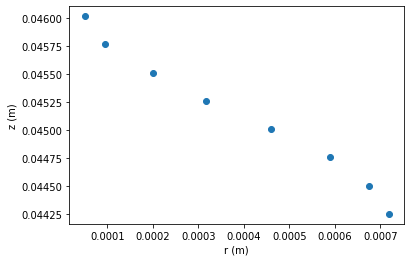

In [97]:
print(zs)
plt.figure(figsize=(6, 4))
plt.scatter(rs, zs)
plt.xlabel("r (m)")
plt.ylabel("z (m)")
plt.show()

We use piecewise linear to fit the measured data. For fude pen we use function piecewise_linear3; while for calligraphy brush we utilize piecewise_linear4.

[ 2.65559230e-04  5.53636283e-04  4.53094035e-02  4.48934114e-02
 -3.06968833e+00 -3.66324702e+00]


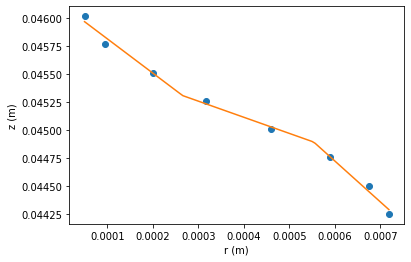

In [98]:
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np

def piecewise_linear(x, x0, y0, k1, k2):
    # x<x0 ? lambda x: k1*x + y0 - k1*x0
    # x>=x0 ? lambda x: k2*x + y0 - k2*x0
    return np.piecewise(x, [x < x0, x >= x0], [lambda x:k1*x + y0-k1*x0,
                                   lambda x:k2*x + y0-k2*x0])

def piecewise_linear3(x,x0,x1,y0,y1,k0,k1):
    return np.piecewise(x , [x <= x0, np.logical_and(x0<x, x<= x1),x>x1] ,
                        [lambda x:k0*(x-x0) + y0,
                         lambda x:(x-x0)*(y1-y0)/(x1-x0)+y0,
                        lambda x:k1*(x-x1) + y1])

def piecewise_linear4(x,x0,x1,x2,y0,y1,y2,k0,k1):
    return np.piecewise(x , [x <= x0, np.logical_and(x0<x, x<= x1),np.logical_and(x1<x, x<= x2),x>x2] ,
                        [lambda x:k0*(x-x0) + y0,
                         lambda x:(x-x0)*(y1-y0)/(x1-x0)+y0,
                         lambda x:(x-x1)*(y2-y1)/(x2-x1)+y1,
                        lambda x:k1*(x-x2) + y2])


# 用已有的 (x, y) 去拟合 piecewise_linear 分段函数
# you have to modify the bounds
# calli brush
#p , e = optimize.curve_fit(piecewise_linear4, rs, zs, bounds=([0.0007,0.0015,0.00215,0.0038,0.0025,-0.002,-20,-20], [0.001,0.0019, 0.0025, 0.005,0.003,-0.0008,-0.5,-0.5]))

# fude pen
p , e = optimize.curve_fit(piecewise_linear3, rs, zs, bounds=([0.0001,0.0005,0,0,-20,-20], [0.0003,0.0006,0.0456,0.04675,-0.5,-0.5]))

xd = np.linspace(rs[0],rs[-1], 100)
plt.plot(rs, zs, "o")
plt.plot(xd, piecewise_linear3(xd, *p))
plt.xlabel("r (m)")
plt.ylabel("z (m)")
print(p) #parameters!!

Thus the callibrated fude pen and brush functions are:

In [ ]:
def func_fude(radii):
    if radii >=0 and radii <= 0.00026555923:
        z = -3.06968833*(radii-0.00026555923)+0.0453094035
    elif radii> 0.00026555923 and radii <= 0.000553636283:
        z = -1.444032*(radii-0.00026555923)+0.0453094035
    elif radii > 0.000553636283 and radii <=0.00071875:
        z = -3.66324702*(radii-0.000553636283)+0.044893411
    else:
        return 0.04425 # overflow protection

In [ ]:
def func_brush(radii):
    if radii >=0 and radii <= 7.72667536e-04:
        z = -5.9701493*(radii - 7.72667536e-04) + 4.34974603e-03
    elif radii > 7.72667536e-04 and radii <= 1.78125854e-03:
        z = -1.538473*(radii -7.72667536e-04) + 4.34974603e-03
    elif radii >1.78125854e-03 and radii <= 2.45866277e-03:
        z = -6.028019*(radii - 1.78125854e-03) + 2.79805600e-03
    elif radii >2.45866277e-03 and radii <0.0045:
        z = -2.37843574*(radii - 2.45866277e-03) - 1.28534957e-03
    else:
        return -0.006
        

For robotic demonstration, we strongly recommend you to re-callibrate and use your own callibrated function.

### 2. Using the callibrated function to process RL states (.npy) into control points (.npz)

In [ ]:
from load_data_try import process

alpha = 0.04 # indicates you are going to write a character with size 4 cm (0.04 m)
beta = 0.5 # contrast of stroke width, can be modified to get the most aesthetic character
choose_func = func_brush

In [ ]:
name = None # YOUR FILE NAME
if not os.path.exists('./data'):
    os.makedirs('./data')
in_dir = './data/'+name+'.npy'
out_dir = './data/'+name+'.npz'

data = np.load(in_dir)
print(len(data))
x, y, z = process(data)
print(np.max(z))
print(np.min(z))
np.savez(out_dir, pos_3d_x=x, pos_3d_y=y, pos_3d_z=z)